In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "CIFAR10"
model_name = "resnet_ce_mse"
ood = "5:6:7:8:9"

In [3]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


100%|██████████| 50000/50000 [00:01<00:00, 34588.60it/s]


Files already downloaded and verified


100%|██████████| 10000/10000 [00:00<00:00, 38958.72it/s]


In [4]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [5]:
# model ids
model_ids = {
    "": "",
    "5:6:7:8:9": "vwaamtbe"
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

5:6:7:8:9 vwaamtbe


In [6]:
model = config.get_model()

In [7]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
from tqdm import tqdm

trn_emb = []
trn_rcn = []
trn_lgt = []

val_emb = []
val_rcn = []
val_lgt = []

ind_emb = []
ind_rcn = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_emb = []
    ood_rcn = []
    ood_lgt = []
    ood_tgt = []
    
rnd_emb = []
rnd_rcn = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

100%|██████████| 313/313 [00:02<00:00, 126.29it/s]


train - OK


100%|██████████| 79/79 [00:00<00:00, 113.92it/s]


val - OK


100%|██████████| 79/79 [00:00<00:00, 122.98it/s]


test InD - OK


100%|██████████| 469/469 [00:02<00:00, 168.14it/s]


test OoD - OK


100%|██████████| 100/100 [00:00<00:00, 223.45it/s]

test RnD - OK


In [10]:
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_rcn = np.array(trn_rcn)

val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_rcn = np.array(val_rcn)

ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_emb.shape, trn_lgt.shape, trn_rcn.shape)
print(val_emb.shape, val_lgt.shape, val_rcn.shape)
print(ind_emb.shape, ind_lgt.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_emb.shape, ood_lgt.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_emb.shape, rnd_lgt.shape, rnd_rcn.shape)

(20000, 128) (20000, 5) (20000, 3, 32, 32)
(5000, 128) (5000, 5) (5000, 3, 32, 32)
(5000, 128) (5000, 5) (5000, 3, 32, 32) (5000,)
(30000, 128) (30000, 5) (30000, 3, 32, 32) (30000,)
(6400, 128) (6400, 5) (6400, 3, 32, 32)


In [11]:
from tsnecuda import TSNE

n = ind_emb.shape[0]

if ood_str:
    all_emb = np.concatenate([ind_emb, ood_emb], axis=0)
else:
    all_emb = ind_emb

emb2d = TSNE(n_components=2, perplexity=100, random_seed=42).fit_transform(all_emb)
ind_emb2d = emb2d[:n]
ood_emb2d = emb2d[n:]
print(ind_emb2d.shape, ood_emb2d.shape)

(5000, 2) (30000, 2)


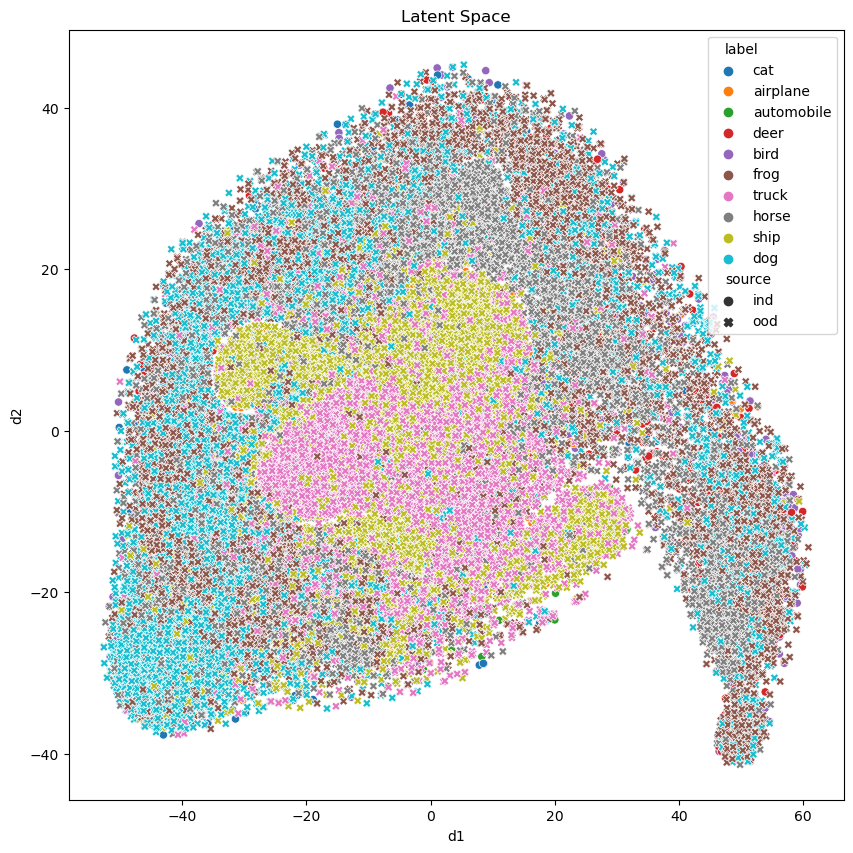

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
ood_labels = [config.labels[i] for i in ood_tgt]

emb_data = pd.DataFrame()
d1, d2 = ind_emb2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

d1, d2 = ood_emb2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Latent Space")
sns.scatterplot(data=emb_data, x="d1", y="d2", style="source", hue="label", ax=ax)
plt.show()

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


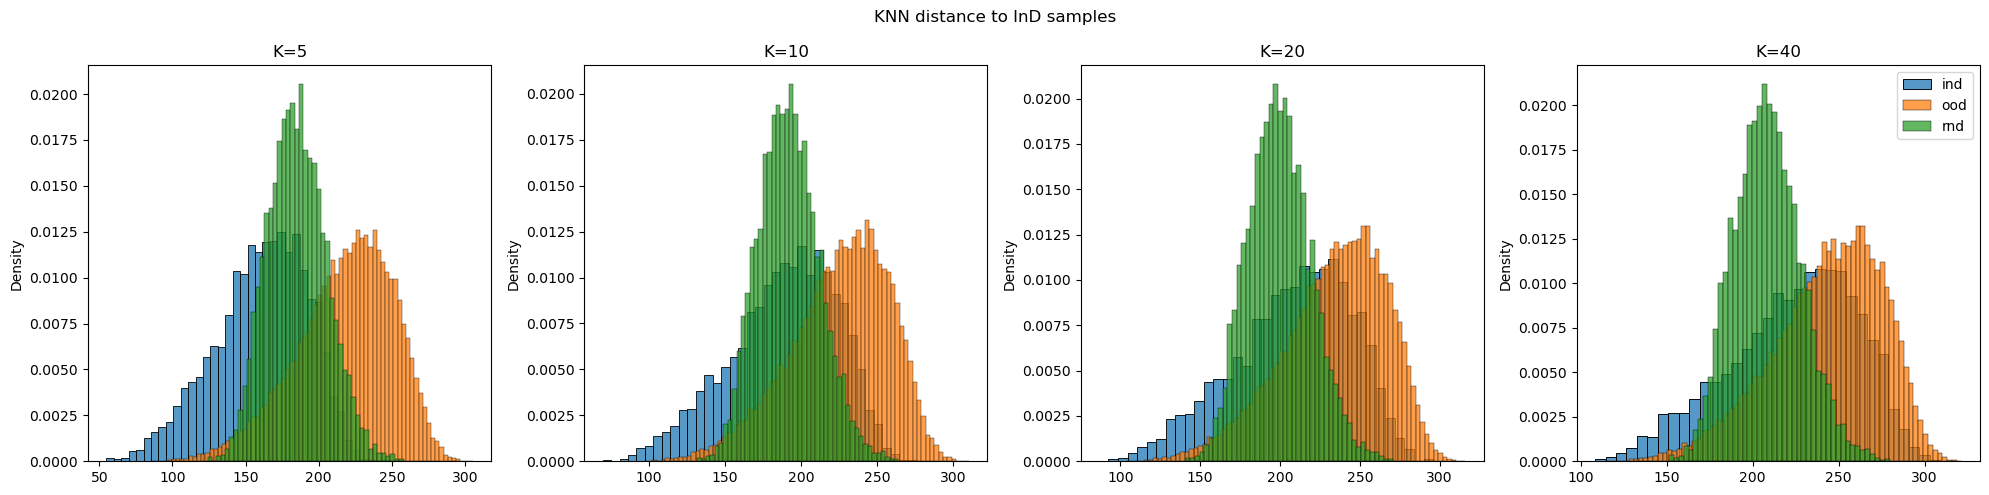

In [13]:
import faiss

index_emb = faiss.IndexFlatL2(ind_emb.shape[-1])
index_emb.add(ind_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("KNN distance to InD samples")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    
    Di, _ = index_emb.search(ind_emb, k)
    Do, _ = index_emb.search(ood_emb, k)
    Dr, _ = index_emb.search(rnd_emb, k)
    ax = axs[j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)
    sns.histplot(Dr.mean(-1), fill=True, label='rnd', stat='density', ax=ax)

plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


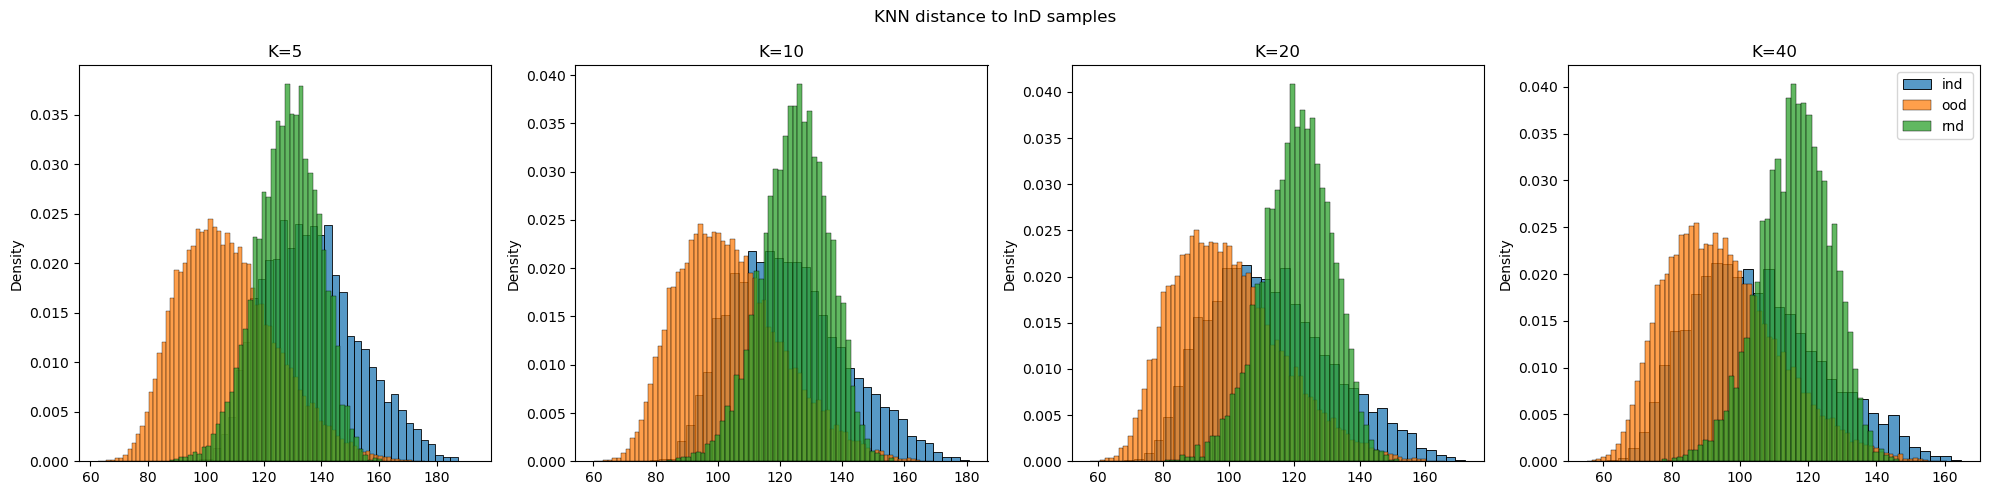

In [14]:
import faiss

index_emb = faiss.IndexFlatIP(ind_emb.shape[-1])
index_emb.add(ind_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("KNN distance to InD samples")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    
    Di, _ = index_emb.search(ind_emb, k)
    Do, _ = index_emb.search(ood_emb, k)
    Dr, _ = index_emb.search(rnd_emb, k)
    ax = axs[j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)
    sns.histplot(Dr.mean(-1), fill=True, label='rnd', stat='density', ax=ax)

plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


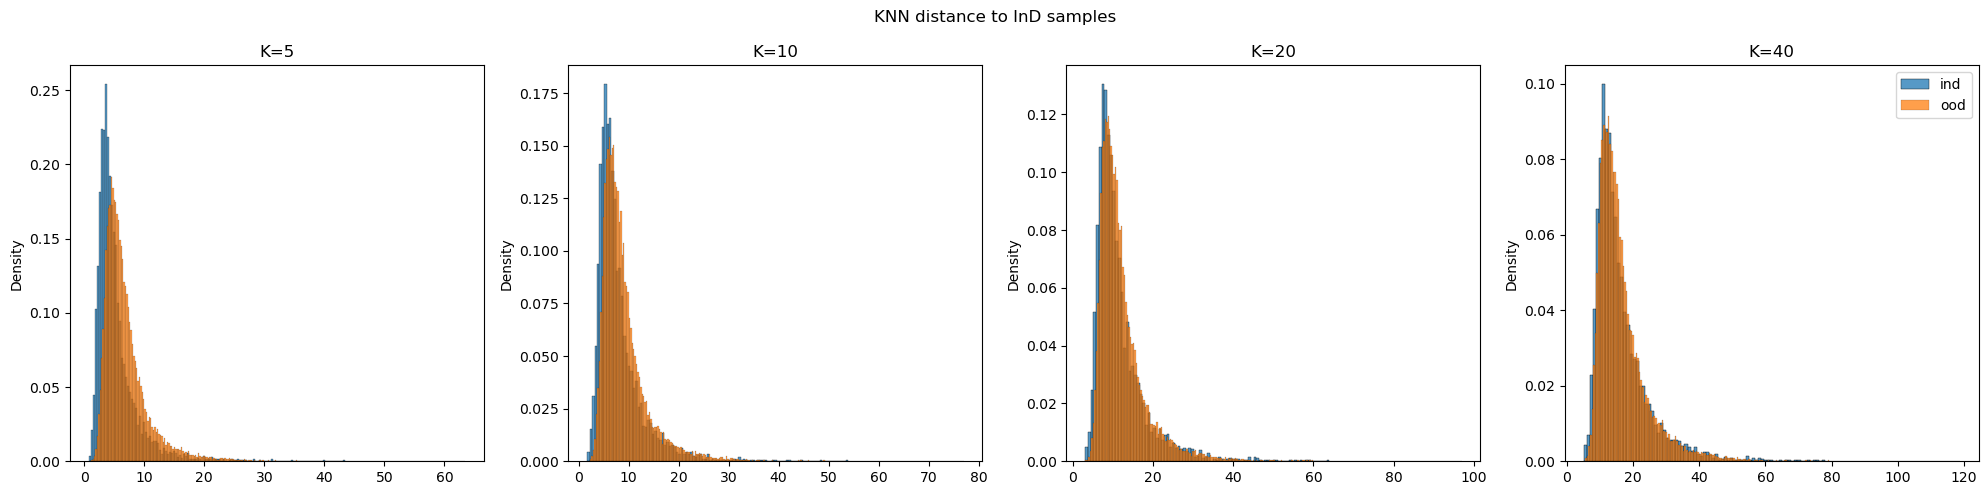

In [15]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("KNN distance to InD samples")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    
    Di, _ = index_lgt.search(ind_lgt, k)
    Do, _ = index_lgt.search(ood_lgt, k)
    ax = axs[j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)

plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


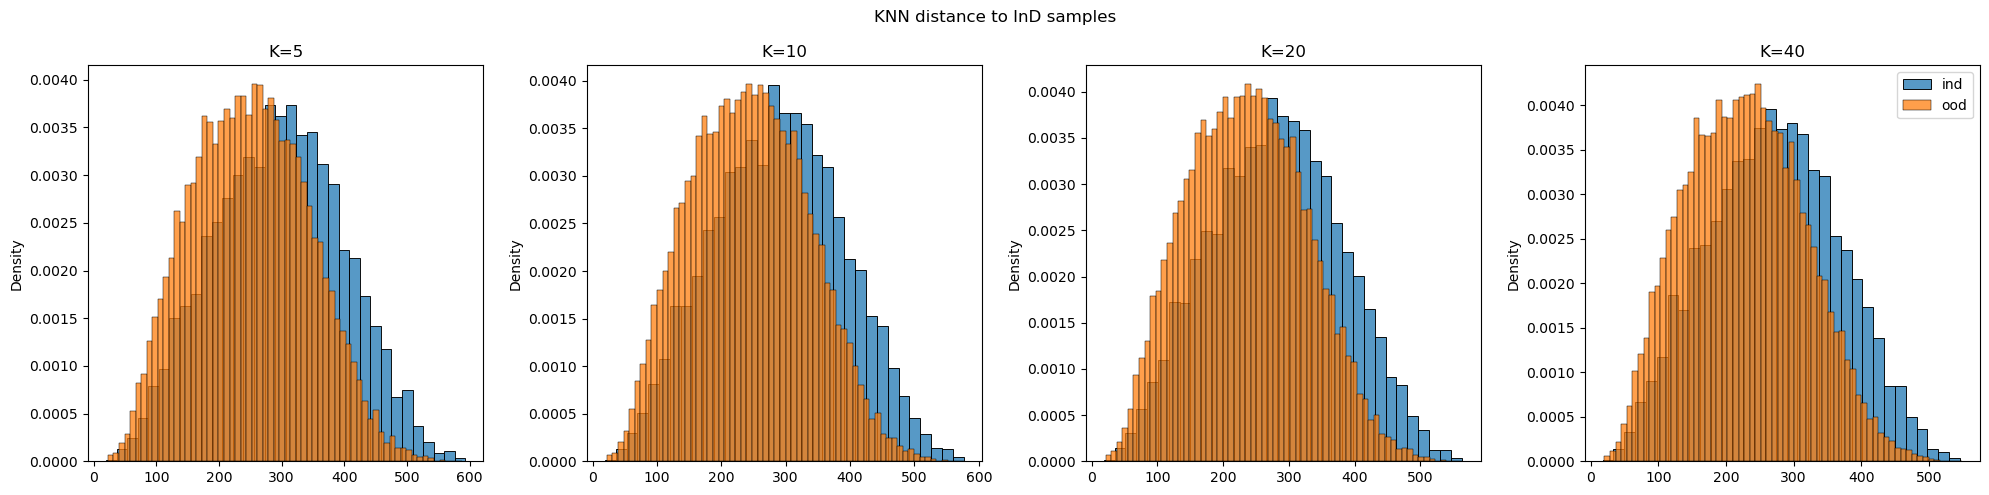

In [16]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle("KNN distance to InD samples")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    
    Di, _ = index_lgt.search(ind_lgt, k)
    Do, _ = index_lgt.search(ood_lgt, k)
    ax = axs[j]
    ax.set_title(f"K={k}")
    sns.histplot(Di.mean(-1), fill=True, label='ind', stat='density', ax=ax)
    sns.histplot(Do.mean(-1), fill=True, label='ood', stat='density', ax=ax)

plt.legend()
plt.tight_layout()
plt.show()